In [1]:
import torch
import matplotlib.pyplot as plt
from torch import optim, distributions, nn
from tqdm.notebook import tqdm
from gpzoo.kernels import MGGP_RBF
from gpzoo.gp import MGGP_SVGP
from gpzoo.likelihoods import GaussianLikelihood

/gladstone/engelhardt/home/lchumpitaz/gitclones/GPzoo/gpzoo/utilities.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
torch.manual_seed(32)

noise_variance = torch.tensor(0.05)
n0, n1 = 100, 100


X0 = distributions.Uniform(-10, 10).sample(sample_shape=(n0,1))
X1 = distributions.Uniform(-10, 10).sample(sample_shape=(n1,1))

X = torch.concatenate([X0, X1], axis=0)
X_groups = torch.concatenate([torch.zeros(n0), torch.ones(n1)]).type(torch.LongTensor)

In [3]:
kernel_true = MGGP_RBF(sigma=1.0, lengthscale=1.0, group_diff_param=1.0)
kernel_true.input_dim = 1
cov = kernel_true.forward(X, X, X_groups, X_groups)+ noise_variance.expand(n0+n1).diag()
Y = distributions.MultivariateNormal(torch.zeros(len(X)), cov).sample()

In [4]:
kernel = MGGP_RBF(sigma=1.0, lengthscale=3.0, group_diff_param=0.001)

M = 50
gp = MGGP_SVGP(kernel, dim=1, M=50, jitter=1e-3, n_groups=2)
gp.Z = nn.Parameter(20.0*torch.rand((2*M, 1))-10.0)

model = GaussianLikelihood(gp, noise=1.0)

In [5]:
def train(model, optimizer, X, groupsX, y, steps=200, E=20):
    losses = []
    for it in tqdm(range(steps)):

        optimizer.zero_grad()
        pY, qF, qU, pU = model(X=X, groupsX=groupsX, E=E)

        ELBO = (pY.log_prob(y)).mean(axis=0).sum()

        ELBO -= torch.sum(distributions.kl_divergence(qU, pU))


        loss = -ELBO
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
    return losses

In [6]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [72]:
losses = train(model, optimizer, X, X_groups, Y, steps=4000, E=100)

  0%|          | 0/4000 [00:00<?, ?it/s]

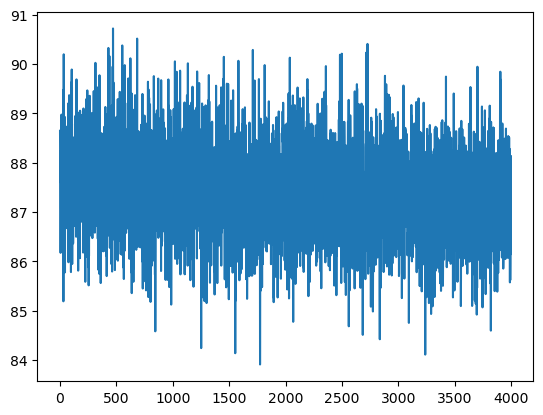

In [73]:
plt.plot(losses)

In [74]:
ntest = 500
Xtest_onegroup = torch.linspace(-10, 10, ntest)[:, None]
Xtest = torch.concatenate([Xtest_onegroup, Xtest_onegroup], axis=0)
Xtest_groups = torch.concatenate([torch.zeros(ntest), torch.ones(ntest)]).type(torch.LongTensor)
pY, qF, qU, pU = model(X=Xtest, groupsX=Xtest_groups, verbose=False)
mean = qF.mean.detach()

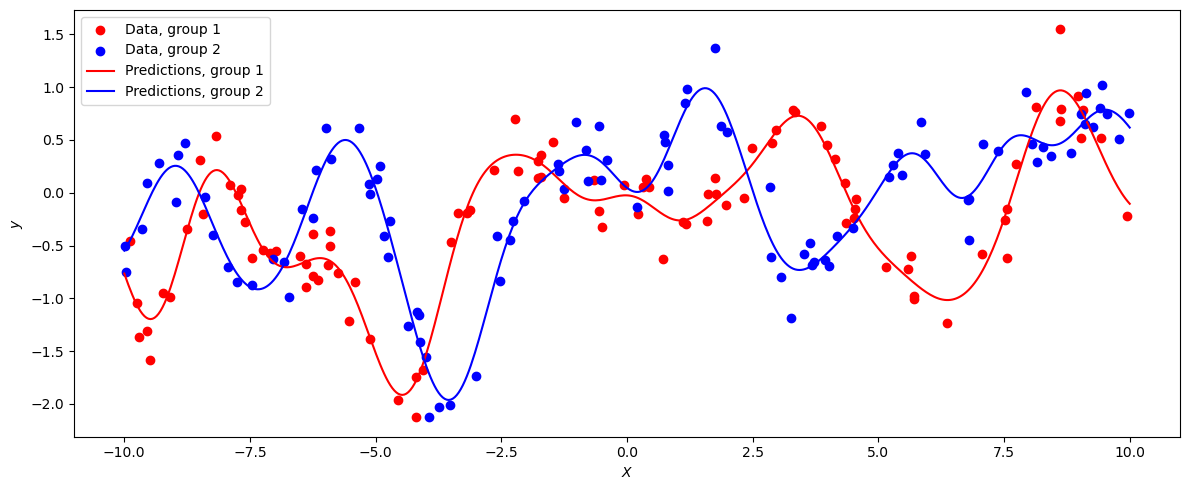

In [75]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.scatter(X[:n0], Y[:n0], color="red", label="Data, group 1")
ax.scatter(X[n0:], Y[n0:], color="blue", label="Data, group 2")
ax.plot(Xtest[:ntest], mean[:ntest], color="red", label="Predictions, group 1")
ax.plot(
    Xtest[ntest:], mean[ntest:], color="blue", label="Predictions, group 2"
)
ax.set_xlabel(r"$X$")
ax.set_ylabel(r"$y$")
ax.legend()
fig.tight_layout()

In [76]:
model.gp.kernel.lengthscale

Parameter containing:
tensor(0.7988, requires_grad=True)

In [77]:
model.gp.kernel.sigma

Parameter containing:
tensor(0.7301, requires_grad=True)

In [78]:
(pY.scale.squeeze()[0])**2.0

tensor(0.0887, grad_fn=<PowBackward0>)

In [79]:
model.gp.kernel.group_diff_param

Parameter containing:
tensor(1.8127, requires_grad=True)

In [81]:
torch.nn.functional.softplus(model.noise)

tensor(0.2979, grad_fn=<SoftplusBackward0>)